In [1]:

import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tapakah68/segmentation-full-body-mads-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/segmentation-full-body-mads-dataset


In [3]:
import os
print(os.listdir(path))
from PIL import Image
image_path  = path + "/segmentation_full_body_mads_dataset_1192_img"
image_path = image_path + "/segmentation_full_body_mads_dataset_1192_img"
print(os.listdir(image_path))

['df.csv', 'segmentation_full_body_mads_dataset_1192_img']
['images', 'masks', 'collages']


In [6]:
import pandas as pd
df = pd.read_csv(path + "/df.csv")
df.head()

,Unnamed: 0,images,masks,collages
0,0,images/HipHop_HipHop1_C0_00180.png,masks/HipHop_HipHop1_C0_00180.png,collages/HipHop_HipHop1_C0_00180.jpg
1,1,images/HipHop_HipHop1_C0_00225.png,masks/HipHop_HipHop1_C0_00225.png,collages/HipHop_HipHop1_C0_00225.jpg
2,2,images/HipHop_HipHop1_C0_00360.png,masks/HipHop_HipHop1_C0_00360.png,collages/HipHop_HipHop1_C0_00360.jpg
3,3,images/HipHop_HipHop1_C0_00405.png,masks/HipHop_HipHop1_C0_00405.png,collages/HipHop_HipHop1_C0_00405.jpg
4,4,images/HipHop_HipHop1_C0_00450.png,masks/HipHop_HipHop1_C0_00450.png,collages/HipHop_HipHop1_C0_00450.jpg


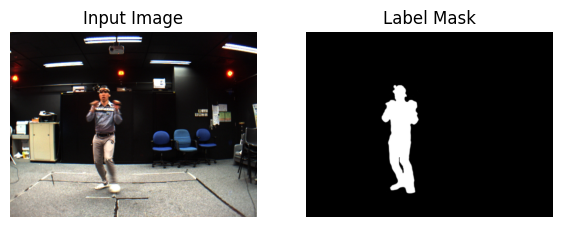

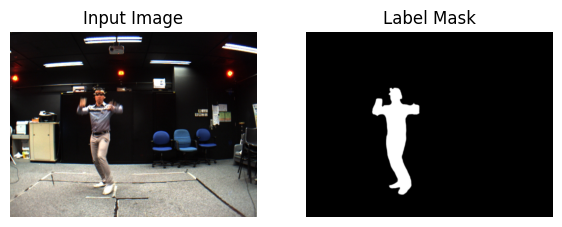

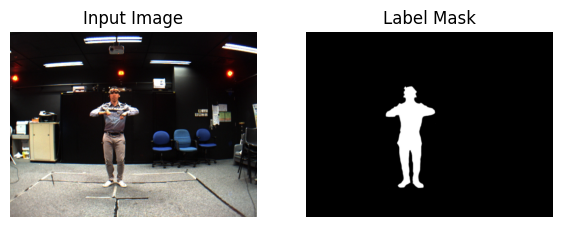

In [7]:
from PIL import Image

for i in range(3):
    input_path = image_path + "/" + df['images'][i]
    plt.figure(figsize=(7, 7))
    with Image.open(input_path) as img:
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')

    label_path = image_path + "/" + df['masks'][i]
    with Image.open(label_path) as img:
        plt.subplot(1,2,2)
        plt.imshow(img)
        plt.title("Label Mask")

        plt.axis('off')
        plt.show()


In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df[["images", "masks"]], test_size=0.2, random_state=42, shuffle=True)
print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 953
Test size: 239


Train dataset size: 953
Test dataset size: 239


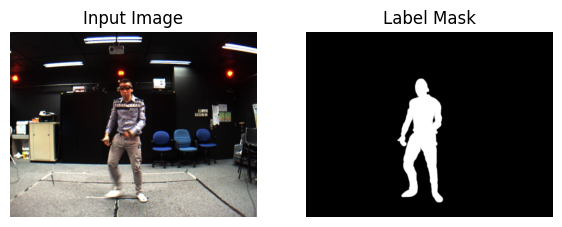

Image shape: torch.Size([3, 384, 512])
Mask shape: torch.Size([1, 384, 512])


In [9]:
from torch.utils.data import Dataset

class ConvertToSegmentationDataset(Dataset):
    def __init__(self, data, complete_dataset_path,transform=None):
        self.data = data
        self.transform = transform
        self.complete_dataset_path = complete_dataset_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        img_path, mask_path = self.data[i]
        img_path, mask_path = (self.complete_dataset_path + "/" + img_path), (self.complete_dataset_path + "/" + mask_path)

        with Image.open(img_path).convert("RGB") as img, Image.open(mask_path).convert("L") as mask:
            if self.transform:
                img = self.transform(img)
                mask = self.transform(mask)
            return img,mask
train_data = ConvertToSegmentationDataset(train_df.values.tolist(),image_path,transform=ToTensor())
test_data = ConvertToSegmentationDataset(test_df.values.tolist(),image_path,transform=ToTensor())
print("Train dataset size:", len(train_data))
print("Test dataset size:", len(test_data))
img, mask = train_data[0]
plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Input Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0),cmap='gray')
plt.title("Label Mask")
plt.axis('off')
plt.show()
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

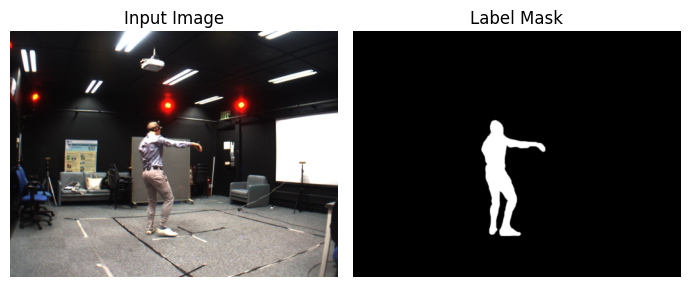

torch.Size([16, 3, 384, 512])


In [10]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
# for img, mask in train_loader:
#     print("Batch size:", img.shape)
#     print("Mask size:", mask.shape)
#     break
for images, masks in train_loader:
    plt.figure(figsize=(7,7))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title("Input Image")
    plt.subplot(1, 2, 2)
    plt.imshow(masks[0].permute(1,2,0), cmap='gray')
    plt.axis('off')
    plt.title("Label Mask")
    plt.tight_layout()
    plt.show()
    print(images.shape)
    break

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # nn.Flatten(3,-1),
            nn.Conv2d(3,16,3,stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16,32,2,stride = 4, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,32,2,stride = 4, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 6 * 8, 256)

        )
        # self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        # self.unpool = nn.MaxUnpool2d(2, 2)
        self.decoder = nn.Sequential(
            nn.Linear(256, 32 * 6 * 8),
            nn.Unflatten(1, (32, 6, 8)),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),
            nn.Upsample(size=(13, 17), mode='nearest'),
            nn.ReLU(),
            nn.ConvTranspose2d(32,32,2,stride = 4, padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,2,stride = 4, padding=1),
            nn.ReLU(),
            #nn.ConvTranspose2d(16,3,3,stride = 2,padding=1)
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


!pip install torchinfo
from torchinfo import summary
torch.manual_seed(42)
my_model = AutoEncoder().to(device)
summary(my_model, input_size=[1, 3, 384, 512],device =device)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 384, 512]          --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Conv2d: 2-1                       [1, 16, 192, 256]         448
│    └─ReLU: 2-2                         [1, 16, 192, 256]         --
│    └─Conv2d: 2-3                       [1, 32, 49, 65]           2,080
│    └─ReLU: 2-4                         [1, 32, 49, 65]           --
│    └─Conv2d: 2-5                       [1, 32, 13, 17]           4,128
│    └─ReLU: 2-6                         [1, 32, 13, 17]           --
│    └─MaxPool2d: 2-7                    [1, 32, 6, 8]             --
│    └─Flatten: 2-8                      [1, 1536]                 --
│    └─Linear: 2-9                       [1, 256]                  393,472
├─Sequential: 1-2                        [1, 1, 384, 512]          --
│    └─Linear: 2-10                      [1, 1536]                 394,75

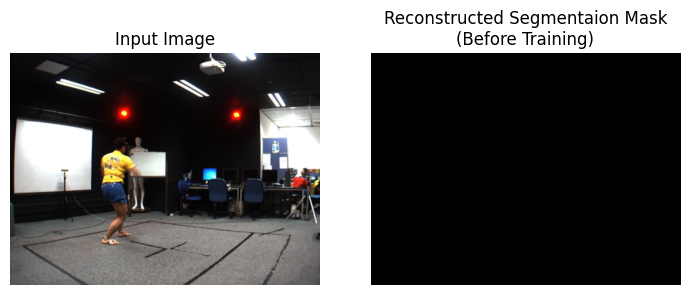

In [12]:

for images, masks in train_loader:
    plt.figure(figsize=(7,7))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title("Input Image")
    plt.subplot(1, 2, 2)
    out = my_model(images[0].unsqueeze(0).to(device))
    out = out.round().to(device)
    plt.imshow(out[0].permute(1,2,0).detach().cpu(),cmap='gray')
    plt.title("Reconstructed Segmentaion Mask\n(Before Training)")
    plt.tight_layout()
    plt.axis('off')
    break

In [13]:
def dice_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum((2, 3))
    denominator = pred.sum((2, 3)) + target.sum((2, 3))


    dice = (2. * intersection + eps) / (denominator + eps)
    return dice.mean()
def iou_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum((2, 3))
    union = pred.sum((2, 3)) + target.sum((2, 3)) - intersection


    iou = (intersection + eps) / (union + eps)
    return iou.mean()

In [14]:
import psutil

def print_memory_usage():
    mem = psutil.virtual_memory()
    print(f"RAM used: {mem.used / 1024**3:.2f} GB / {mem.total / 1024**3:.2f} GB")


def train_loop(model, data_loader, loss_fn, optimizer, device):
    dice = 0
    iou = 0
    print_memory_usage()
    model.train()
    train_loss = 0
    for X, y in data_loader:

        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        dice += dice_score(y_pred, y).item()
        iou += iou_score(y_pred, y).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    average_train_loss = train_loss / len(data_loader)
    average_dice_score = dice / len(data_loader)
    average_iou_score = iou / len(data_loader)
    return average_train_loss, average_dice_score, average_iou_score

In [15]:
def test_loop(model, data_loader, loss_fn, device):
    model.eval()
    test_loss = 0
    dice = 0
    iou = 0
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            dice += dice_score(y_pred, y).item()
            iou += iou_score(y_pred, y).item()
    average_test_loss = test_loss / len(data_loader)
    average_dice_score = dice / len(data_loader)
    average_iou_score = iou / len(data_loader)


    return average_test_loss, average_dice_score, average_iou_score

In [16]:
def train_the_model(epochs,loss_fn,optimizer,model,train_loader,test_loader,device):
    train_losses = []
    train_dices = []
    train_ious = []
    test_losses = []
    test_dices = []
    test_ious = []

    for epoch in range(epochs):
        train_loss,train_dice,train_iou= train_loop(model,train_loader, loss_fn, optimizer,device)
        test_loss,test_dice,test_iou= test_loop(model,test_loader, loss_fn, device)
        print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_dice_score: {train_dice:.4f} |"
                f"train_iou_score: {train_iou:.4f} |"

                f"test_loss: {test_loss:.4f} | "
                f"tes_dice_score: {test_dice:.4f} |"
                f"test_iou_score: {test_iou:.4f} |"
            )
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        train_ious.append(train_iou)
        test_losses.append(test_loss)
        test_dices.append(test_dice)
        test_ious.append(test_iou)
    return train_losses,train_dices,train_ious,test_losses,test_dices,test_ious

In [17]:
loss_fn = nn.MSELoss()
epochs = 10
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)
train_losses,train_dices,train_ious,test_losses,test_dices,test_ious = train_the_model(epochs, loss_fn, optimizer, my_model, train_loader, test_loader, device)


RAM used: 1.42 GB / 12.67 GB
Epoch: 1 | train_loss: 0.1684 | train_dice_score: 0.0024 |train_iou_score: 0.0012 |test_loss: 0.1409 | tes_dice_score: 0.0000 |test_iou_score: 0.0000 |
RAM used: 2.04 GB / 12.67 GB
Epoch: 2 | train_loss: 0.1168 | train_dice_score: 0.0000 |train_iou_score: 0.0000 |test_loss: 0.0938 | tes_dice_score: 0.0000 |test_iou_score: 0.0000 |
RAM used: 2.05 GB / 12.67 GB
Epoch: 3 | train_loss: 0.0777 | train_dice_score: 0.0000 |train_iou_score: 0.0000 |test_loss: 0.0662 | tes_dice_score: 0.0003 |test_iou_score: 0.0002 |
RAM used: 2.03 GB / 12.67 GB
Epoch: 4 | train_loss: 0.0588 | train_dice_score: 0.0054 |train_iou_score: 0.0027 |test_loss: 0.0541 | tes_dice_score: 0.0110 |test_iou_score: 0.0056 |
RAM used: 1.93 GB / 12.67 GB
Epoch: 5 | train_loss: 0.0500 | train_dice_score: 0.0253 |train_iou_score: 0.0129 |test_loss: 0.0479 | tes_dice_score: 0.0552 |test_iou_score: 0.0286 |
RAM used: 1.94 GB / 12.67 GB
Epoch: 6 | train_loss: 0.0450 | train_dice_score: 0.0593 |train_io

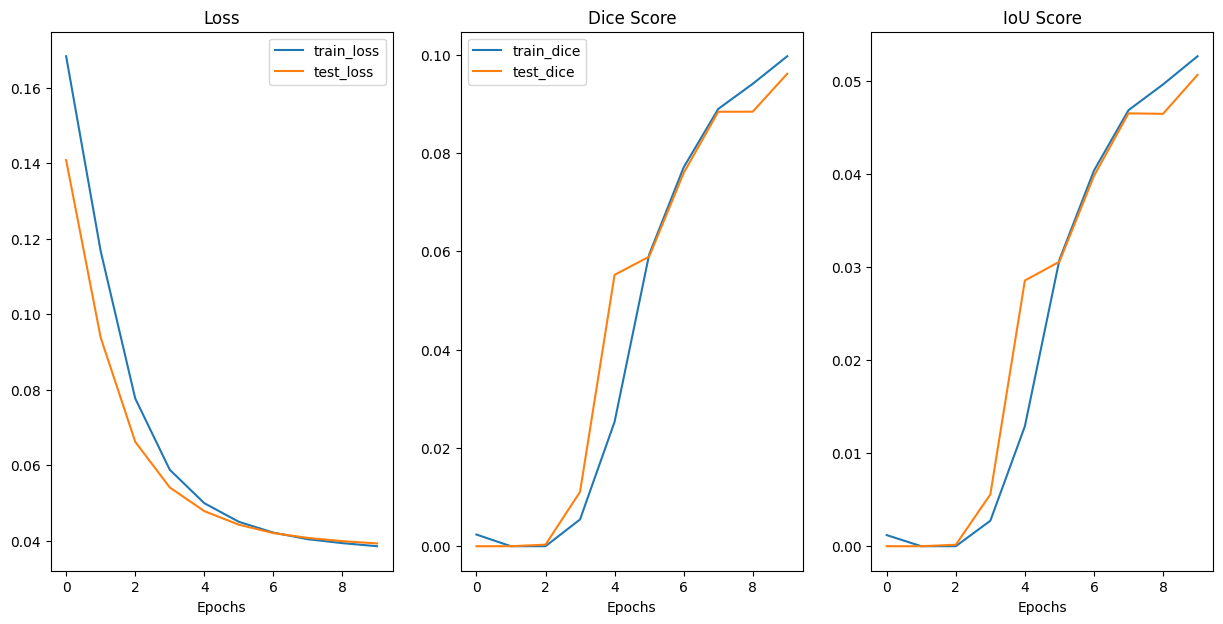

In [18]:
def model_plots(epochs,train_losses,test_losses):
    temp = epochs
    epochs = [i for i in range (temp)]
    plt.figure(figsize = (15,7))
    plt.subplot(1,3,1)
    plt.plot(epochs, train_losses, label='train_loss')
    plt.plot(epochs, test_losses, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(epochs, train_dices, label='train_dice')
    plt.plot(epochs, test_dices, label='test_dice')
    plt.title('Dice Score')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(epochs, train_ious, label='train_iou')
    plt.plot(epochs, test_ious, label='test_iou')
    plt.title('IoU Score')
    plt.xlabel('Epochs')
    epochs = temp
model_plots(epochs,train_losses,test_losses)

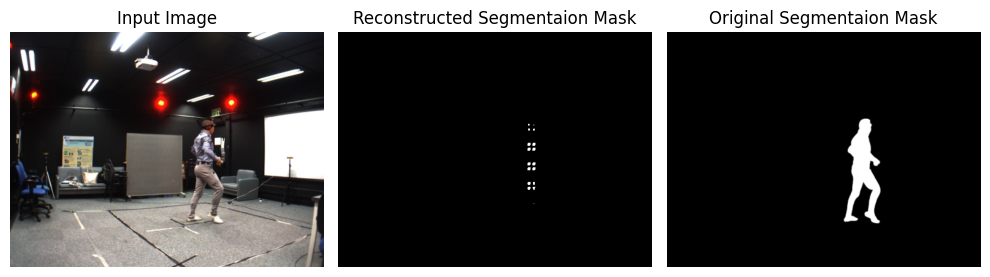

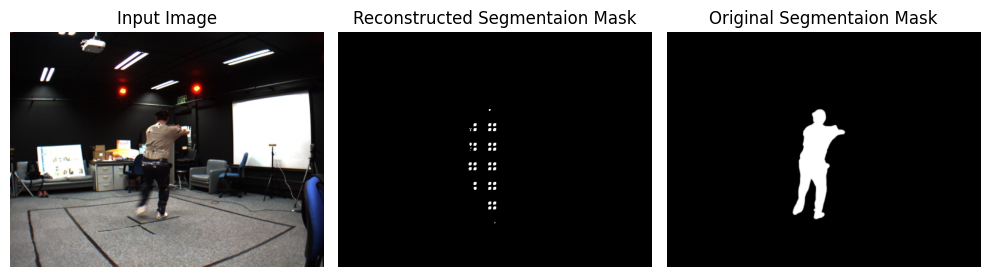

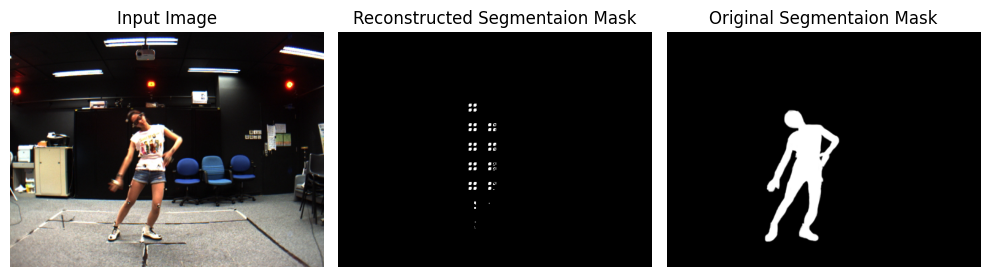

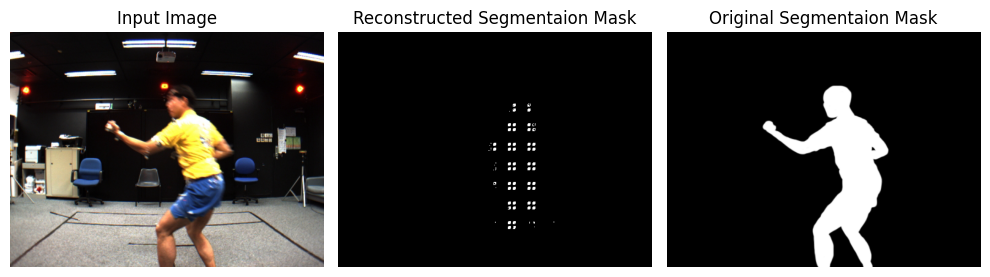

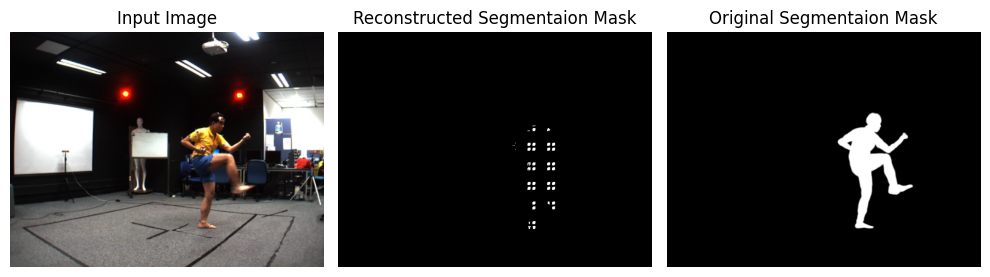

In [21]:
count = 0
for images, masks in train_loader:
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title("Input Image")
    plt.subplot(1, 3, 2)
    out = my_model(images[0].unsqueeze(0).to(device))
    out = out.round().to(device)
    plt.imshow(out[0].permute(1,2,0).detach().cpu(),cmap='gray')
    plt.title("Reconstructed Segmentaion Mask")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(masks[0].permute(1, 2, 0).detach().cpu(), cmap='gray')
    plt.title("Original Segmentaion Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    count += 1
    if count == 5:
        break